# 大作业第四题：大乐透

### 题目
请以中国体彩网（https://www.zhcw.com）为数据源，完成以下任务：
1. 爬取截至2025年7月1日之前100期的大乐透开奖数据和中奖情况（链接：https://www.zhcw.com/kjxx/dlt/ ），分析大乐透总销售额随开奖日期的变化趋势并预测2025年7月1日之后最近一期的销售额。
2. 根据爬取的大乐透数据对前区号码与后区号码进行频率统计与可视化，分析其历史分布规律。根据你发现的规律或者采用其他预测方法推荐一组大乐透号码，作为2025年7月1日之后最近一期的投注号码。
3. 根据爬取的大乐透数据，分别统计周一、周三、周六的大乐透开奖号码和总销售额。对比不同开奖日之间的号码分布与销售额特征，分析是否存在显著差异或相似性。
4. 爬取任意一个彩种中20位以上专家的公开数据，对专家的基本属性（彩龄、发文量等）和表现（中奖情况）进行统计分析，并通过可视化展示其分布规律、相互关系或对中奖率的影响。

**数据源： 中国体彩网（https://www.zhcw.com）**


### 第一问
1. 爬取2025年7月1日前100期的大乐透开奖数据和中奖情况

In [1]:
import requests
import pandas as pd
import json
from datetime import datetime

all_data = []   # 存放所有数据
pageSize = 30   # 正常访问网站默认就是30个
count = 200     # 由于7月份已经有部分开奖，所以截取200个结果，然后再筛选
# 网址模板
url_template = "https://jc.zhcw.com/port/client_json.php?callback=jQuery1122015460234579236576_1752041563554&transactionType=10001001&lotteryId=281&issueCount={count}&startIssue=&endIssue=&startDate=&endDate=&type=0&pageNum={pageNum}&pageSize={pageSize}&tt=0.8413918146118788&_=1752041563555"
# request报文头
headers = {
    "Accept":"*/*",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "zh-CN,zh;q=0.9",
    "Connection": "keep-alive",
    "Cookie": "Hm_lvt_2b09927a5895e3946dc6de8526befc81=1751271125; HMACCOUNT=FE256CFD6BE151DF; __utmc=245691549; __utmz=245691549.1751271125.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utma=245691549.1797249563.1751271125.1751348969.1751434944.3; __utmt=1; __utmb=245691549.6.10.1751434944; Hm_lpvt_2b09927a5895e3946dc6de8526befc81=1751435220",
    "Host": "jc.zhcw.com",
    "Referer": "https://www.zhcw.com/",
    "Sec-Fetch-Dest": "script",
    "Sec-Fetch-Mode": "no-cors",
    "Sec-Fetch-Site": "same-site",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36",
    "sec-ch-ua": '"Not/A)Brand";v="8", "Chromium";v="126", "Google Chrome";v="126"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
}

# 通过修改网址来连续获取数据
for pageNum in range(1, (count // pageSize) + 2):
    url = url_template.format(count=count, pageNum=pageNum, pageSize=pageSize)
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching page {pageNum}: {response.status_code}")
        continue

    data = response.text
    data = data[data.index('(') + 1:data.rindex(')')]  # 提取括号内的内容
    data = json.loads(data)  # 将字符串转换为JSON格式
    all_data.append(data)

# 将所有数据提取合并
res = []
for i in range(count // pageSize + 1):
    temp = all_data[i]['data']
    res.extend(temp)

for item in res:
    item['openTime'] = datetime.strptime(item['openTime'], '%Y-%m-%d')
    item['issue'] = int(item['issue'])
    item['saleMoney'] = int(item['saleMoney'])
    item['prizePoolMoney'] = float(item['prizePoolMoney'])

# 保留 2025-07-01 前100期数据
while res and res[0]['openTime'] >= datetime(2025,7,1):
    recent = res.pop(0)

while len(res) > 100:
    res.pop()  # 删除超过100期的数据

#删除无关变量
del all_data, count, data, i, item, pageNum, pageSize, response, temp, url, url_template

# 将数据转换为DataFrame并重命名列
res.append(recent)
res = pd.DataFrame(res)
res.rename(columns={
    'issue': '期号',
    'openTime': '开奖时间',
    'frontWinningNum': '前区号码',
    'backWinningNum': '后区号码',
    'seqFrontWinningNum': '有序前区号码',
    'seqBackWinningNum': '有序后区号码',
    'saleMoney': '销售额',
    'prizePoolMoney': '奖池金额',
    'week': '开奖星期',
    'winnerDetails': '中奖详情'
}, inplace=True)
res.drop(columns=['r9SaleMoney'], inplace=True)  # 删除无用的列
recent = res.iloc[100]
res = res.iloc[:100]
res['顺序'] = 100 - res.index

# 保存到本地
res.to_csv('大乐透100期数据excel版.csv',encoding='ansi',index=False) #Excel使用utf8会乱码
res.to_csv('大乐透100期数据.csv',encoding='utf8',index=False)

2. 提取出这100期的销售额，然后绘图观察趋势

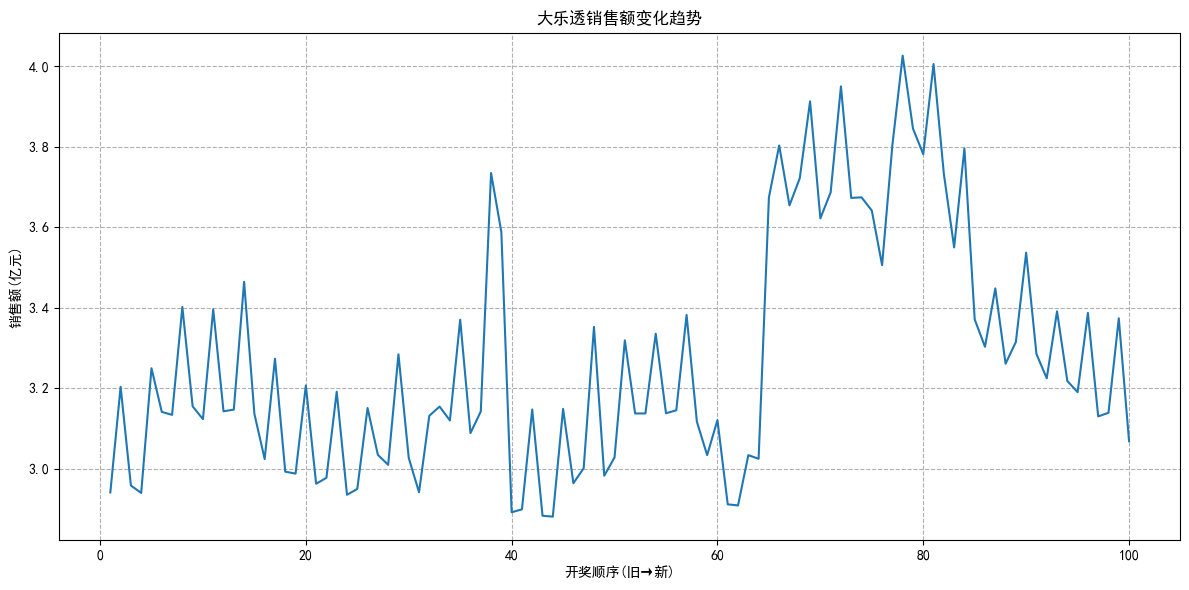

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制销售额的折线图
saleMoney = res['销售额']/100000000.0  #将销售额转换为亿元
fig0 = plt.figure(figsize=(12, 6))  # 设置图形大小
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
plt.plot(res['顺序'],saleMoney)
plt.title('大乐透销售额变化趋势')
plt.xlabel('开奖顺序(旧→新)')
plt.ylabel('销售额(亿元)')
plt.tight_layout()  # 自动调整布局
plt.savefig('01-大乐透销售额变化趋势.png')  # 保存图像
del saleMoney  # 删除无用变量

***ps.这里我们假定2025-07-01前最近的一期为第100期，往前数99期为第1期***<br>
根据折线图我们可以观察到，抛去60到80之间的骤然升高，历史的数据呈现“上-下-下”循环趋势<br>
而2025-07-01之前两期正好呈现“上-下”的趋势，根据观察到的规律，下一期也应处于“下”的趋势<br>
所以我们预测下一期的销售额和上一期基本一致，大概是3.05亿元，我们和真实的销售额进行比较后发现预测一致

In [3]:
print('2025-07-01 后最近一期的信息')
display(recent)

2025-07-01 后最近一期的信息


期号                                                    25074
开奖时间                                    2025-07-02 00:00:00
前区号码                                         02 11 15 18 21
后区号码                                                  05 10
有序前区号码                                       11 18 02 15 21
有序后区号码                                                10 05
销售额                                               304472528
奖池金额                                          1661629014.25
开奖星期                                                    星期三
中奖详情      [{'awardEtc': '1', 'baseBetWinner': {'remark':...
Name: 100, dtype: object

### 第二问
1. 我们先看一看中奖号码的历史规律

In [4]:
#把str转换成list
res['前区号码'] = res['前区号码'].apply(lambda x: [int(num) for num in x.split(' ')])
res['有序前区号码']= res['有序前区号码'].apply(lambda x: [int(num) for num in x.split(' ')])
res['后区号码'] = res['后区号码'].apply(lambda x: [int(num) for num in x.split(' ')])
res['有序后区号码'] = res['有序后区号码'].apply(lambda x: [int(num) for num in x.split(' ')])

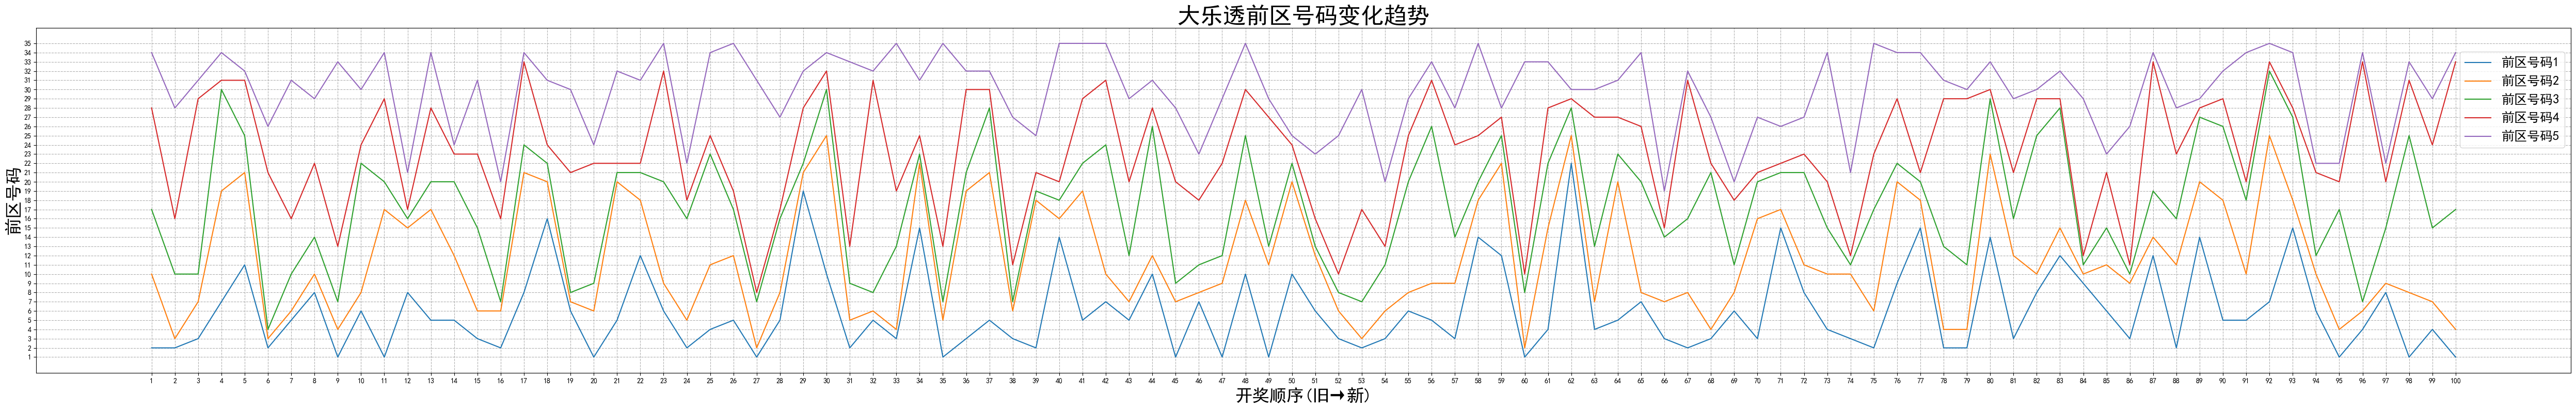

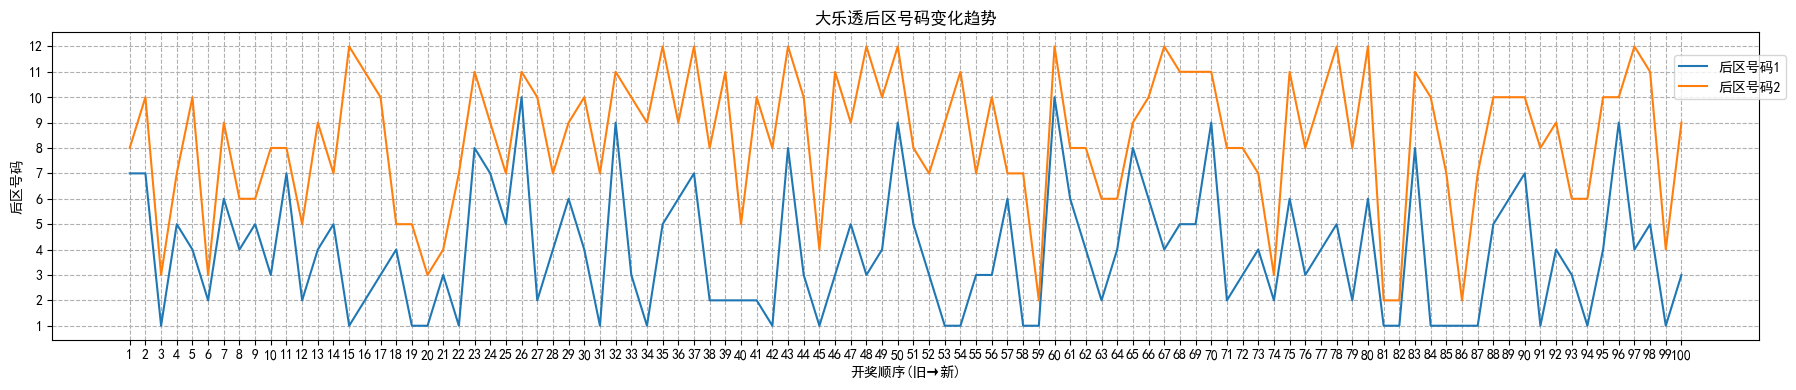

In [5]:
fig1 = plt.figure(figsize=(50, 8))
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
plt.plot(res['顺序'],res['前区号码'].apply(lambda x: x[0]), label='前区号码1')
plt.plot(res['顺序'],res['前区号码'].apply(lambda x: x[1]), label='前区号码2')
plt.plot(res['顺序'],res['前区号码'].apply(lambda x: x[2]), label='前区号码3')
plt.plot(res['顺序'],res['前区号码'].apply(lambda x: x[3]), label='前区号码4')
plt.plot(res['顺序'],res['前区号码'].apply(lambda x: x[4]), label='前区号码5')
plt.ylabel('前区号码', fontsize=24)
plt.xlabel('开奖顺序(旧→新)', fontsize=24)  # 设置x轴标签和位置
plt.xticks(range(1, 101))  # 设置x轴刻度
plt.yticks(range(1,36))
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1,0.95))  # 设置图例位置和字体大小
plt.title('大乐透前区号码变化趋势', fontsize=32)
plt.tight_layout()  # 自动调整布局
plt.savefig('02-1-前区号码变化趋势.png')  # 保存图像

fig2 = plt.figure(figsize=(18, 4))
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
plt.plot(res['顺序'],res['后区号码'].apply(lambda x: x[0]), label='后区号码1')
plt.plot(res['顺序'],res['后区号码'].apply(lambda x: x[1]), label='后区号码2')
plt.title('大乐透后区号码变化趋势')
plt.xlabel('开奖顺序(旧→新)')
plt.ylabel('后区号码')
plt.xticks(range(1, 101))  # 设置x轴刻度
plt.yticks(range(1,13))
plt.legend(loc='upper right', bbox_to_anchor=(1.02,0.95))  # 设置图例位置和字体大小
plt.tight_layout()
plt.savefig('02-2-后区号码变化趋势.png')  # 保存图像

***ps.受制于屏幕大小的限制，图片在放大后观察更为清晰***

2. 然后我们统计一下在前区和后区每个数字出现的频率

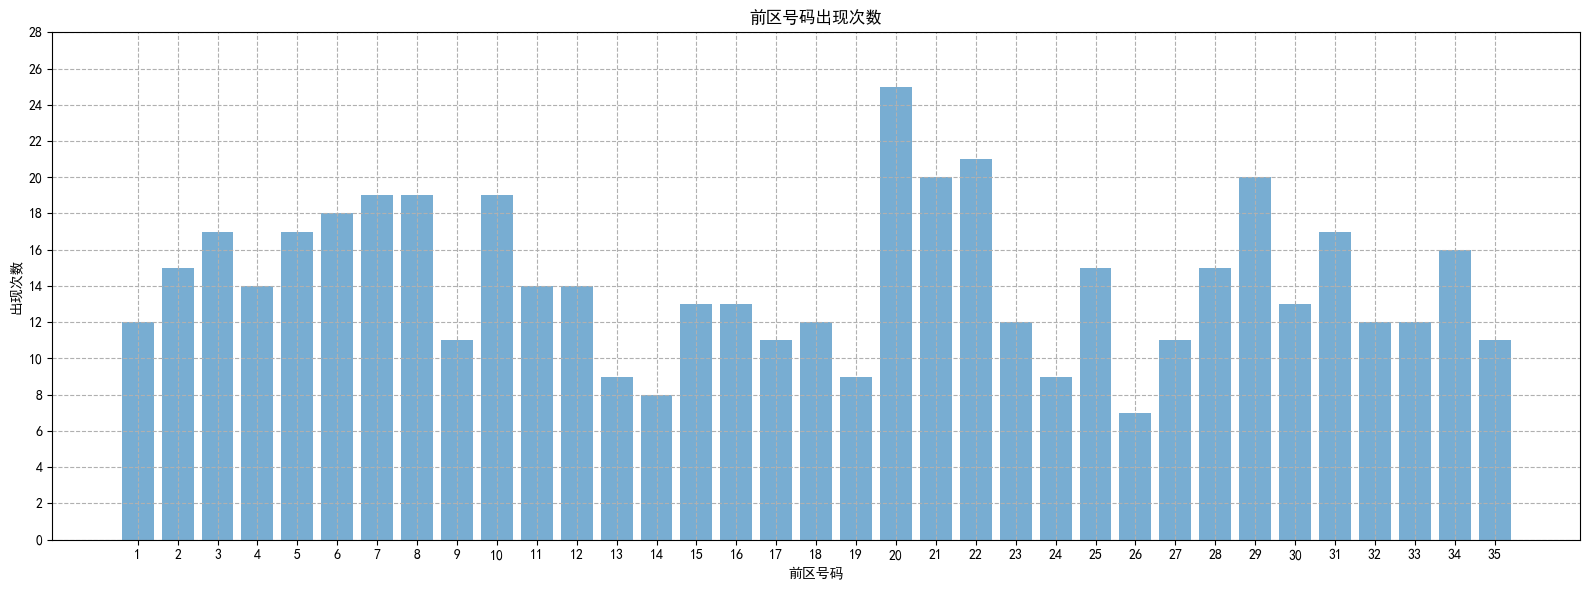

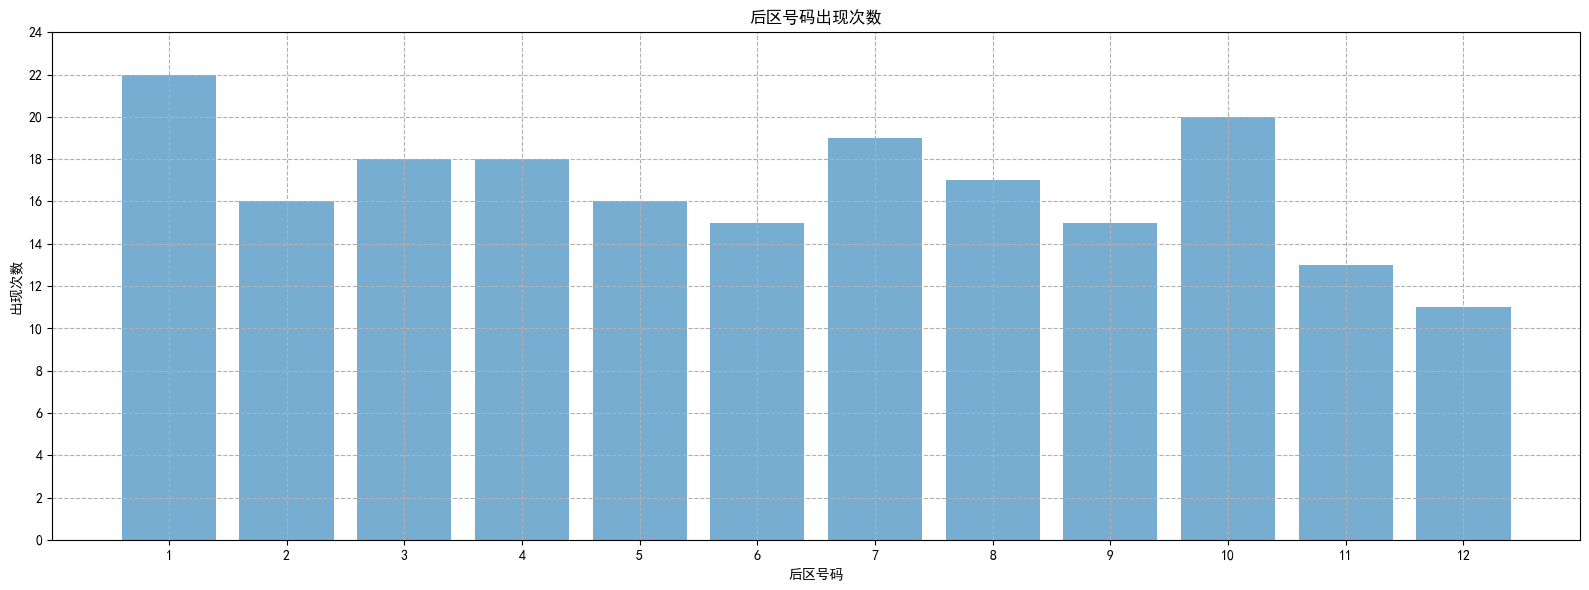

In [6]:
frontCount = res['前区号码'].explode().value_counts().sort_index()
backCount = res['后区号码'].explode().value_counts().sort_index()

fig3 = plt.figure(figsize=(16, 6))
plt.bar(frontCount.index, frontCount.values, label='前区号码', alpha=0.6)
plt.title('前区号码出现次数')
plt.xlabel('前区号码')
plt.ylabel('出现次数')
plt.yticks(range(0,30,2))
plt.xticks(range(1,36))
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
plt.tight_layout()
plt.savefig('02-3-前区号码出现次数.png')  # 保存图像

fig4 = plt.figure(figsize=(16, 6))
plt.bar(backCount.index, backCount.values, label='后区号码', alpha=0.6)
plt.title('后区号码出现次数')
plt.xlabel('后区号码')
plt.ylabel('出现次数')
plt.yticks(range(0,25,2))
plt.xticks(range(1,13))
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
plt.tight_layout()
plt.savefig('02-4-后区号码出现次数.png')  # 保存图像

del frontCount, backCount  # 删除无用变量

- 根据折线图的观察，我们大致可以看到球很大概率是在“上下”循环，有时会有“上下下”和“下上上”的情形，至于更多连着升和连着降的情形则更为少见。
- 而在柱状图的观察中，我们发现R20（R-red-前区，20为球号）独树一帜，出现的频率最高为25%，B1（B-blue-后区）则在后区中出现的频率略高一些。
- 结合以上的分析，再根据前2期的中奖数据，我想给出的预测号码是(29)(25)(20)(10)(4) | (4)(10)。

### 第三问
1. 我们分别筛选出周一周三周六的中奖信息：

In [7]:
subres = [res[res['开奖星期'] == '星期一'].copy(), 
          res[res['开奖星期'] == '星期三'].copy(), 
          res[res['开奖星期'] == '星期六'].copy()]
for i in range(3):
    subres[i].drop(columns=['顺序'], inplace=True)
    subres[i].reset_index(drop=True, inplace=True)

2. 对齐最近一次的开奖日期，绘制销售额图像然后观察：

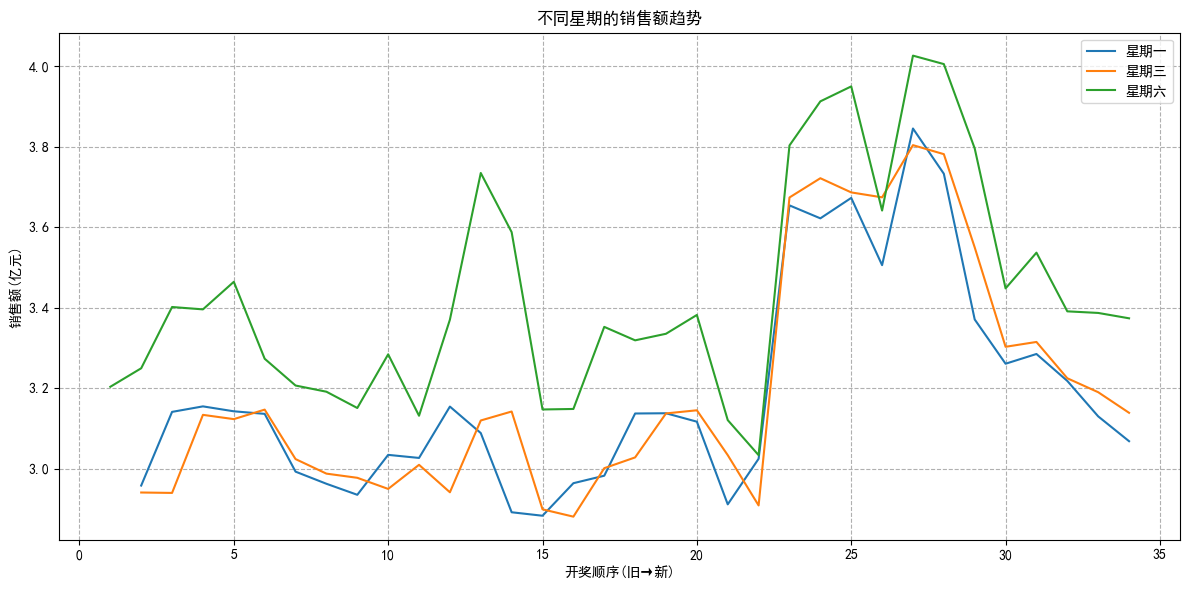

In [ ]:
figMoney = plt.figure(figsize=(12, 6))  # 设置图形大小
plt.grid(True, linestyle='--', alpha=1)  # 添加网格线
for i in range(3):
    if i == 0:
        addstr = '星期一'
    elif i == 1:
        addstr = '星期三'
    else:
        addstr = '星期六'
    plt.plot(34 - subres[i].index, subres[i]['销售额']/100000000, label=addstr)
    plt.xlabel('开奖顺序(旧→新)')
    plt.ylabel('销售额(亿元)')
    plt.title('不同星期的销售额趋势')
    plt.legend()
plt.tight_layout()  # 自动调整布局
plt.savefig('03-1-不同星期的销售额趋势.png')  # 保存图像
del addstr, i

- 根据观察，我们发现星期一和星期三的销售额大抵相近，而星期六的销售额普遍上要比星期一和星期三的销售额要多

3. 然后我们再看一看号码分布和星期的关系：

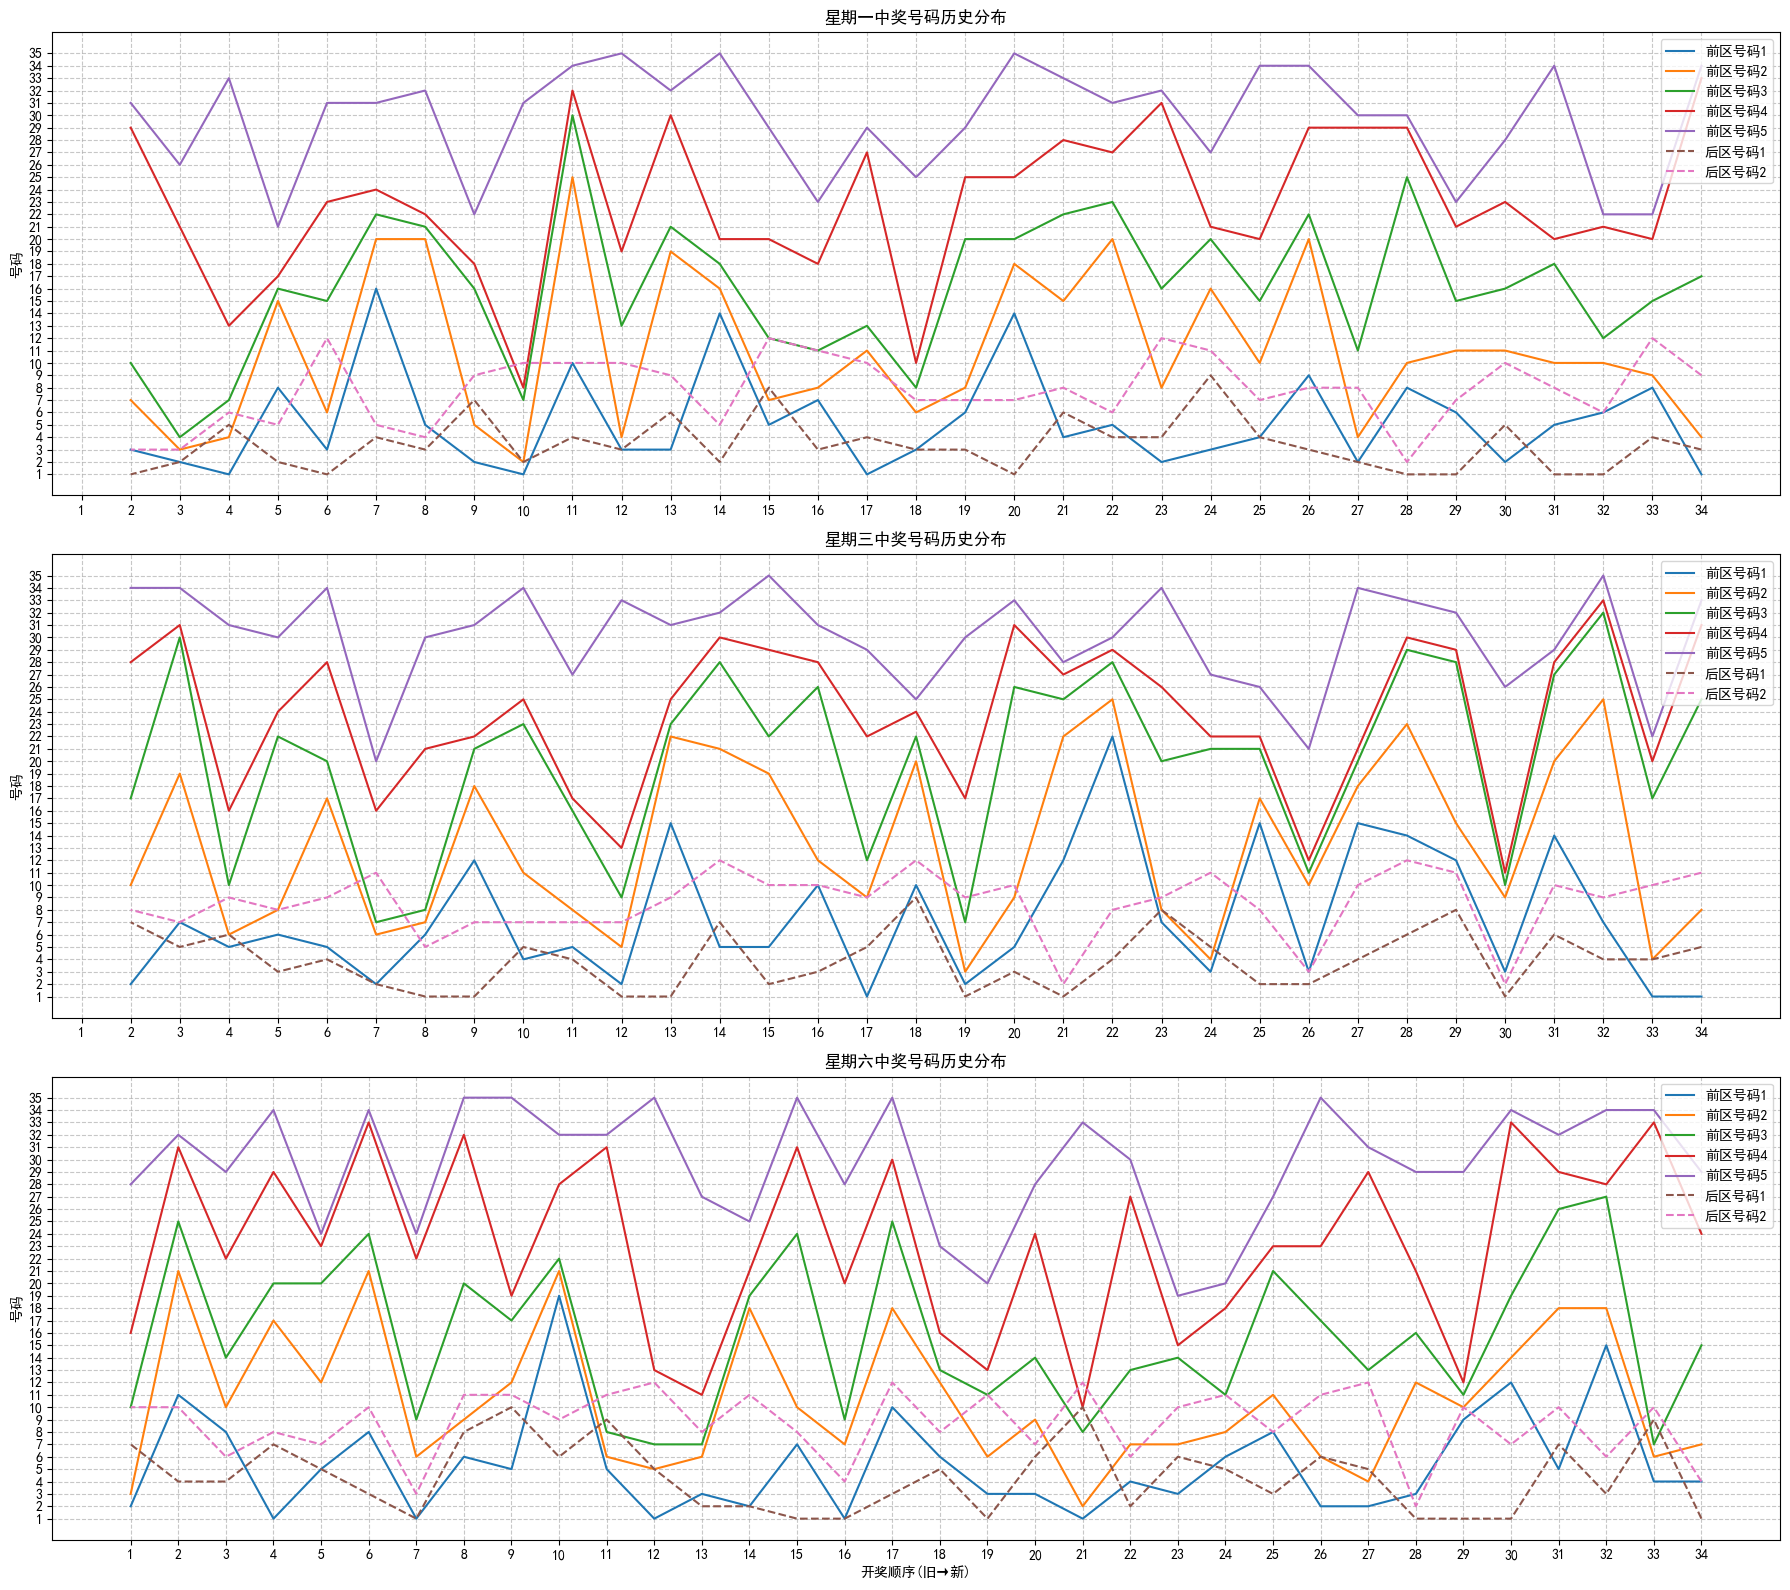

In [9]:
figNumber, axes = plt.subplots(3, 1, figsize=(18, 16), sharex=False)
weekdays = ['星期一', '星期三', '星期六']
for i in range(3):
    for j in range(5):
        axes[i].plot(34 - subres[i].index, subres[i]['前区号码'].apply(lambda x: x[j]), label=f'前区号码{j+1}')
    for j in range(2):
        axes[i].plot(34 - subres[i].index, subres[i]['后区号码'].apply(lambda x: x[j]), linestyle='--', label=f'后区号码{j+1}')
    axes[i].set_title(f'{weekdays[i]}中奖号码历史分布')
    axes[i].set_ylabel('号码')
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].set_xticks(range(1, 35))
    axes[i].set_yticks(range(1, 36))
    axes[i].grid(True, linestyle='--', alpha=0.7)
axes[-1].set_xlabel('开奖顺序(旧→新)')
plt.tight_layout()
plt.savefig('03-2-不同星期的中奖号码分布.png')

- 经过观察，中奖号码与星期的关系微乎其微，并没有比较明显的分布规律

In [10]:
del axes, i, j, subres, weekdays

### 第四问
1. 我们先爬取大乐透总榜的前20位专家：

In [11]:
# 修改limit让他爬取100位专家(limit默认是10)
url = "https://i.cmzj.net/expert/rankingList?limit={counter}&page=1&lottery=22&type={expertType}"
counter = 20
expertType = 4  # 2->双色球，4->大乐透

resp = requests.get(url.format(counter=counter, expertType=expertType))
txt = resp.json()
txt = txt['data']
expert = pd.DataFrame(txt)

expert.drop(columns=[
    'lottery', 'follow', 'addTime', 'targetScore', 'title', 'bbxId', 'one', 'two', 'three', 'z1', 'z2', 'z3', 'z4'
], inplace=True)

2. 然后根据他们的专家ID去爬取他们的详细信息，把两张表连接起来合成一张表：

In [12]:
extraExpert=[]
url = "https://i.cmzj.net/expert/queryExpertById?expertId={id}"
for i in range(counter):
    id = expert.iloc[i]['expertId']
    resp = requests.get(url.format(id=id))
    txt = resp.json()
    txt = txt['data']
    extraExpert.append(txt)

extraExpert = pd.DataFrame(extraExpert)
extraExpert = extraExpert[['skills', 'age', 'fans', 'articles', 'ssqOne', 'ssqTwo', 'ssqThree', 'dltOne', 'dltTwo', 'dltThree']]

expert = pd.concat([expert, extraExpert], axis=1)

del url, counter, expertType, resp, txt, i, id

*精简版（只关注大乐透不关注双色球的中奖信息）*

In [13]:
expertMain = pd.DataFrame(expert[['rankSort', 'name', 'age', 'fans', 'articles', 'dltOne', 'dltTwo', 'dltThree', 'gradeName']])
expertMain.rename(columns={
    'rankSort':'大乐透总榜排名',
    'name':'昵称',
    'age':'彩龄',
    'fans':'粉丝量',
    'articles':'发文量',
    'dltOne':'大乐透一等奖',
    'dltTwo':'大乐透二等奖',
    'dltThree':'大乐透三等奖',
    'gradeName':'专家等级称号'
}, inplace=True)

3. 然后我们统计一下专家排名和中奖信息

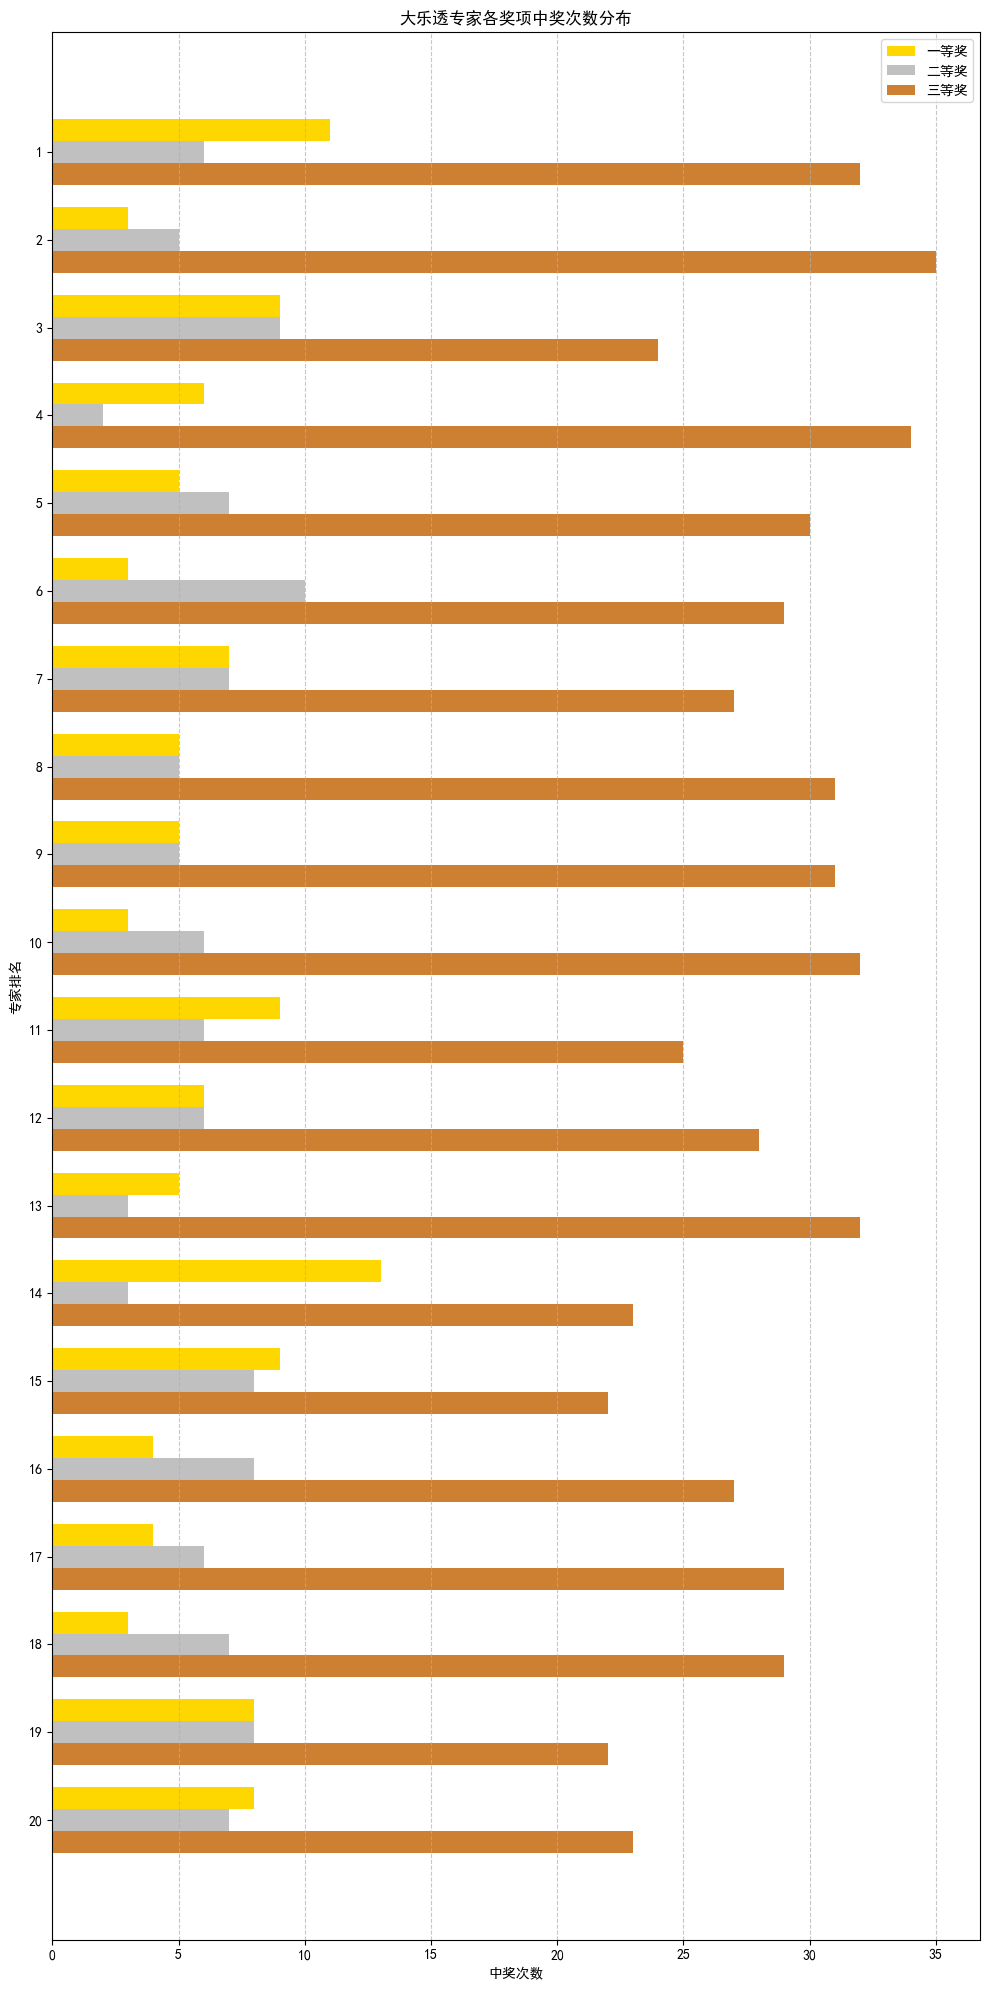

In [14]:
figExpert = plt.figure(figsize=(10, 20))
width = 0.25
y = expertMain['大乐透总榜排名']
bar1 = plt.barh(y - width, expertMain['大乐透一等奖'], height=width, label='一等奖', color='gold')
bar2 = plt.barh(y, expertMain['大乐透二等奖'], height=width, label='二等奖', color='silver')
bar3 = plt.barh(y + width, expertMain['大乐透三等奖'], height=width, label='三等奖', color='#cd7f32')
plt.ylabel('专家排名')
plt.xlabel('中奖次数')
plt.title('大乐透专家各奖项中奖次数分布')
plt.yticks(expertMain['大乐透总榜排名'])
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # 反转y轴
plt.tight_layout()
plt.savefig('04-1-大乐透专家各奖项中奖次数分布.png')
del y, width, bar1, bar2, bar3

4. 统计专家彩龄和排名，发文量与排名，排名与粉丝量的关系，并简单采用线性回归曲线拟合

R² = 0.1148


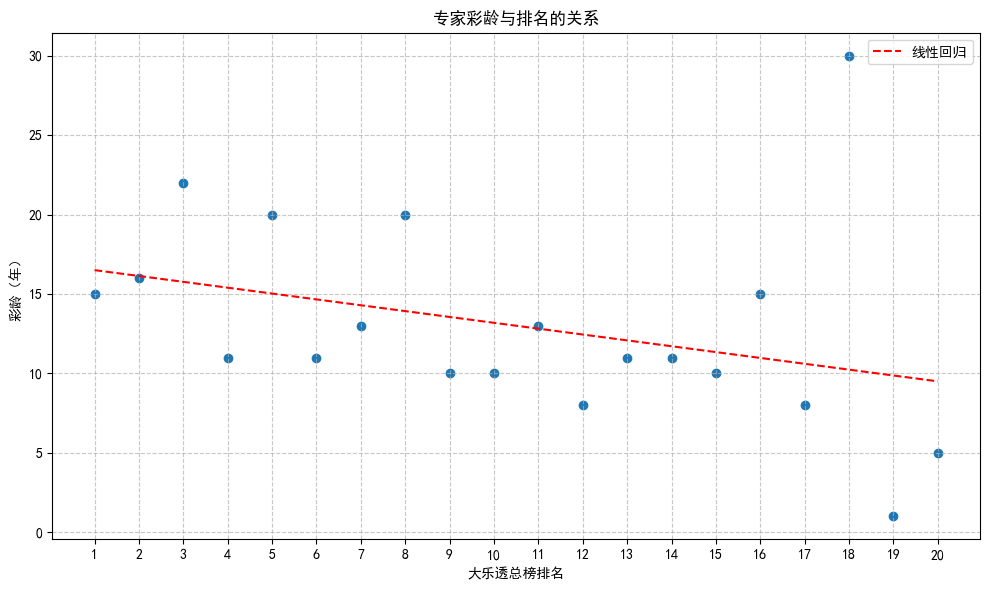

In [15]:
import numpy as np

figAge = plt.figure(figsize=(10, 6))
x = expertMain['大乐透总榜排名']
y = expertMain['彩龄']
plt.scatter(x, y)           # 绘制散点图

# 拟合一条一阶线性回归曲线
coef = np.polyfit(x, y, 1)  # 线性回归的系数
poly1d_fn = np.poly1d(coef) # 回归直线的函数
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='线性回归')

plt.xlabel('大乐透总榜排名')
plt.ylabel('彩龄（年）')
plt.xticks(range(1, 21))    # 设置x轴刻度
plt.title('专家彩龄与排名的关系')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# 输出拟合优度R²
y_pred = poly1d_fn(x)                # 预测值
rss = np.sum((y - y_pred) ** 2)      # 残差平方和
tss = np.sum((y - np.mean(y)) ** 2)  # 总平方和
r2 = 1 - rss / tss
print(f"R² = {r2:.4f}")

plt.savefig('04-2-专家彩龄与排名的关系.png')

R² = 0.0422


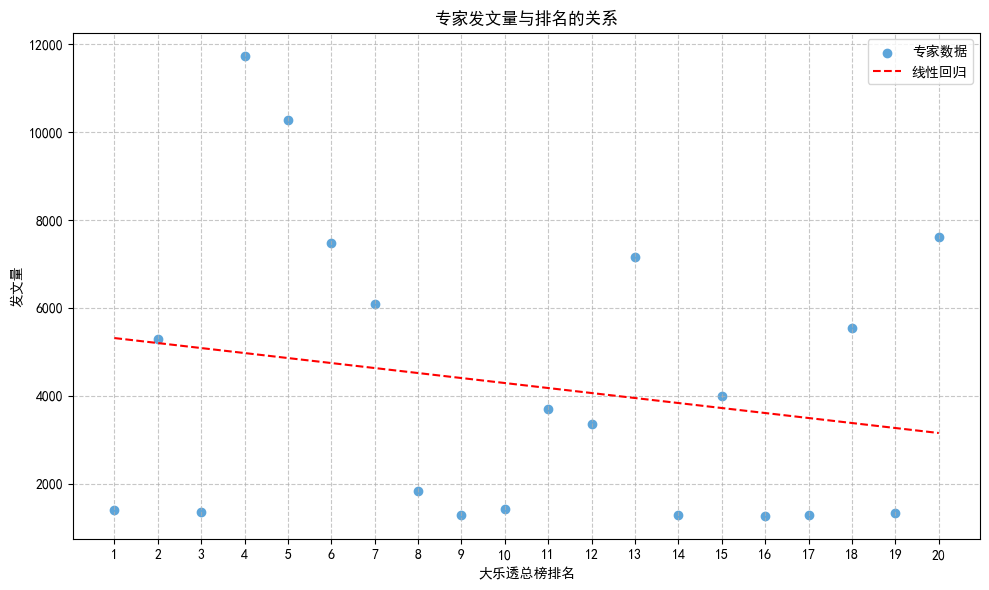

In [16]:
figArticle = plt.figure(figsize=(10, 6))
x = expertMain['大乐透总榜排名']
y = expertMain['发文量']
plt.scatter(x, y, color='#5DA5DA', label='专家数据')

# 线性回归拟合
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='线性回归')

plt.xlabel('大乐透总榜排名')
plt.ylabel('发文量')
plt.title('专家发文量与排名的关系')
plt.xticks(range(1, 21))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
# 输出拟合优度R²
y_pred = poly1d_fn(x)
rss = np.sum((y - y_pred) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - rss / tss
print(f"R² = {r2:.4f}")

plt.savefig('04-3-专家发文量与排名的关系.png')

R² = 0.0101


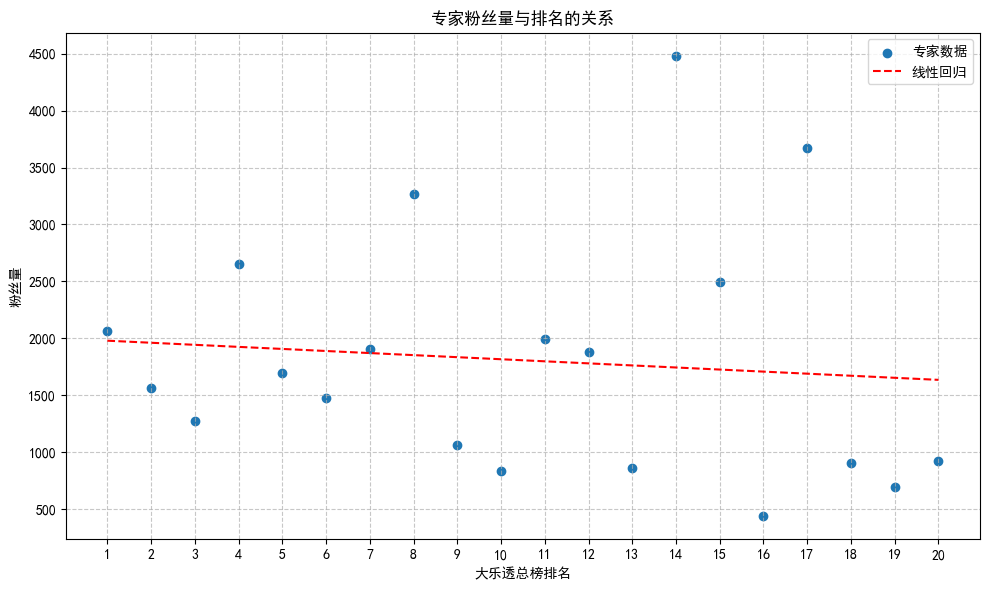

In [17]:
figFans = plt.figure(figsize=(10, 6))
x = expertMain['大乐透总榜排名']
y = expertMain['粉丝量']
plt.scatter(x, y, label='专家数据')

# 线性回归拟合
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), color='red', linestyle='--', label='线性回归')

plt.xlabel('大乐透总榜排名')
plt.ylabel('粉丝量')
plt.title('专家粉丝量与排名的关系')
plt.xticks(range(1, 21))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# 输出拟合优度R²
y_pred = poly1d_fn(x)
rss = np.sum((y - y_pred) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - rss / tss
print(f"R² = {r2:.4f}")

plt.savefig('04-4-专家粉丝量与排名的关系.png')

- 线性模型的决定系数都不是很高，我认为是因为我们所采取的样本数比较少，波动性比较强，也有可能是我们采取的回归模型并不是最佳的。
- 但对比他们的数值大小，以及根据我们的常识可知，彩龄对中奖率的影响比发文量的影响更大。
- 至于专家排名（中奖率）对粉丝量的影响采用的拟合的决定系数更低了，我认为是因为这仅仅是大乐透的排行，我们并没有综合双色球以及其他彩种的中奖信息对他进行分析，样本是片面的不是普遍的。

In [18]:
del coef, poly1d_fn, x, y, y_pred, rss, tss, r2

### 总结
这道题围绕大乐透开奖数据展开，系统完成了数据爬取、清洗、分析与可视化等工作。<br>

1. 爬取了2025年7月1日前100期的大乐透开奖信息和销售额的数据，分析了销售额的变化趋势并对未来一期进行了合理预测。
2. 统计并可视化了前区与后区号码的历史分布规律，结合频率与走势简单给出了投注建议。
3. 比较了不同开奖日（周一、三、六）的销售额与号码分布，发现销售额在周六普遍较高，但号码分布与星期关系不大。
4. 爬取并分析了20位大乐透专家的基本信息与历史战绩，探讨了彩龄、发文量、粉丝量等因素与专家排名、中奖情况的关系。<br>

整体来看，数据分析与可视化有效揭示了大乐透开奖的部分规律，也为后续的预测与决策提供了数据支撑，之后也可以考虑接入大模型来更准确的分析历史分布规律并给出预测。但由于彩票本身的随机性，分析结果仅供参考。